In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from circuit_breaker.cb import cb
from scipy.stats import norm
from sklearn.metrics import \
accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from time import time

pd.options.mode.chained_assignment = None  # default='warn'

# Performance Metrics

In [5]:
def train_detection(data, method, cb, bootstrap_n = 300, k = 3, noise_prop = 0.05):
    methods = {
        'dbscan': {
            'tune': cb.tune_dbscan,
            'train': cb.train_dbscan,
            'test': cb.test_dbscan
        },
        'knn': {
            'tune': cb.tune_knn,
            'train': cb.train_knn,
            'test': cb.test_knn
        }
    }
    norm_data = pd.DataFrame()
    abnorm_data = pd.DataFrame()

    cb.reset()
    data = data.drop('Step', axis = 1, errors='ignore').dropna()
    bootstrap = data.iloc[:bootstrap_n]
    norm_i, abnorm_i = methods[method]['tune'](\
    bootstrap.drop(labels=output_label, axis=1, errors='ignore'), \
                                               noise_prop=noise_prop)
    train_data = bootstrap.iloc[sorted(norm_i)]
    norm_data = norm_data.append(train_data)
    abnorm_data = abnorm_data.append(bootstrap.iloc[abnorm_i])
    methods[method]['train'](train_data.drop(labels=output_label, axis=1, \
                                             errors='ignore'))

    for i in range(bootstrap_n, data.shape[0]):
        if method == 'dbscan':
            methods[method]['test'](train_data.drop(labels=output_label, axis=1, \
            errors='ignore'), data.iloc[i].drop(labels=output_label, errors='ignore'))
        else:
            methods[method]['test'](data.iloc[i].drop(labels=output_label, \
                                                      errors='ignore'))

        if cb.alert:
            abnorm_data = abnorm_data.append(data.iloc[i])
            cb.reset()
        else:
            train_data = train_data.append(data.iloc[i])
            if method != 'dbscan':
                methods[method]['train'](train_data.drop(labels=output_label, axis=1, \
                                                         errors='ignore'))
            norm_data = norm_data.append(data.iloc[i])

#         print(i, data.shape[0] - i)
    
    return norm_data, abnorm_data

In [217]:
def train_credit(credit_score, data, warmup, test_size=1):
    true_warmup = find_index(data, warmup)
    if not true_warmup:
        true_warmup = 2
        
    train_data = data[:true_warmup]
    
    while sum(train_data['Good'].values) == len(train_data['Good'].values) \
    or sum(train_data['Good'].values) == 0:
        true_warmup += 1
        train_data = data[:true_warmup]
        
    test_data = data[true_warmup:]
    results = pd.DataFrame(index=test_data.index, columns=["Target", "Pred"])
    k = 0

    while test_data.shape[0] != 0:
        # index test
        test_index = test_data.index[:test_size]

        # train model
        credit_score.fit(train_data.drop(labels=output_label, axis=1).values, \
                         train_data[output_label].values)
        train_obs = train_data[output_label].values
        train_pred = credit_score.predict(train_data.drop(labels=output_label, \
                                                          axis=1))
        
        # train metrics
        results.loc[test_index, "Accuracy"] = accuracy_score(train_obs, train_pred)
        results.loc[test_index, "Precision"] = precision_score(train_obs, train_pred)
        results.loc[test_index, "Recall"] = recall_score(train_obs, train_pred)
        results.loc[test_index, "F1"] = f1_score(train_obs, train_pred)
        
        #print('Size: ', len(train_obs))
        
        y_score = credit_score.decision_function(train_data\
                                .drop(labels=output_label, axis=1))
        results.loc[test_index, "AUC"] = roc_auc_score(train_obs, y_score)
        
        # test model
        test_pred = credit_score.predict(test_data.iloc[:test_size].\
                    drop(labels=output_label, axis=1).values) 
        results.loc[test_index, "Pred"] = test_pred
        test_obs = test_data.iloc[:test_size][output_label]
        results.loc[test_index, "Target"] = test_obs.values

        # update data
        if test_size > 1:
            new_train_end = test_data.index[0] + test_size
            new_train_index = find_index(train_data, new_train_end)
            new_test_start = test_data.index[0] + test_size
            new_test_index = find_index(test_data, new_test_start)
        else:
            new_train_index = test_size
            new_test_index = test_size
        
        train_data = pd.concat([train_data, test_data.iloc[:new_train_index].copy()])
        test_data = test_data.iloc[new_test_index:].copy()
        
        k += 1

#         print(k, test_data.shape[0])
    
    return results

In [195]:
def train_nn_detection(data, cb = credit_cb, bootstrap_n = 250):
    norm_data = pd.DataFrame()
    abnorm_data = pd.DataFrame()

    cb.reset()
    data = data.drop('Step', axis = 1, errors='ignore').dropna()
    bootstrap = data.iloc[:bootstrap_n]
    warmup_preds = cb.tune_nn(bootstrap\
    .drop(labels=[output_label, 'abnorm'], axis=1, errors='ignore'), \
                             bootstrap['abnorm'])
    for i in range(len(bootstrap)):
        if warmup_preds[i]:
            abnorm_data = abnorm_data.append(bootstrap.iloc[i])
        else:
            norm_data = norm_data.append(bootstrap.iloc[i])

    cb.train_nn(bootstrap.drop(\
    labels=[output_label, 'abnorm'], axis=1, errors='ignore'), bootstrap['abnorm'])

    for i in range(bootstrap_n, len(data)):
        cb.test_nn(data.iloc[i]\
        .drop(labels=[output_label, 'abnorm'], errors='ignore'))
        cb.train_nn(data.iloc[:i]\
                    .drop(labels=[output_label, 'abnorm'], axis=1, errors='ignore'), \
                    data['abnorm'].iloc[:i])

        if cb.alert:
            abnorm_data = abnorm_data.append(data.iloc[i])
            cb.reset()
        else:
            norm_data = norm_data.append(data.iloc[i])

        print(i, data.shape[0] - i)
    
    return norm_data, abnorm_data

In [8]:
def plot_perf_new(results_1, results_2, method, noise, tpt=False):
    if tpt:
        alpha = 0.8
    else:
        alpha = 1.0
    where = where_gen(results_1)
    results_1 = pad_df(results_1)
    
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(nrows=2, ncols=2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.fill_between(results_1.index, results_1['Accuracy'], \
                     np.repeat(0, len(results_1.index)), \
                     where=where, label=method, color='C1')
    ax0.fill_between(results_2.index, results_2['Accuracy'], \
                     np.repeat(0, len(results_2.index)), \
                     where=where, label='All data', color='C0', alpha=alpha)
    ax0.set_title('Accuracy')
    ax0.set_ylim(0.7, 1)
    ax0.legend()

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.fill_between(results_1.index, results_1['F1'], \
                     np.repeat(0, len(results_1.index)), \
                     where=where, label=method, color='C1')
    ax1.fill_between(results_2.index, results_2['F1'], \
                     np.repeat(0, len(results_2.index)), \
                     where=where, label='All data', color='C0', alpha=alpha)
    ax1.set_title('F1')
    ax1.set_ylim(0.7, 1)
    ax1.legend()

    ax2 = fig.add_subplot(gs[1, :])
    ax2.fill_between(results_1.index, results_1['AUC'], \
                     np.repeat(0, len(results_1.index)), \
                     where=where, label=method, color='C1')
    ax2.fill_between(results_2.index, results_2['AUC'], \
                     np.repeat(0, len(results_2.index)), \
                     where=where, label='All data', color='C0', alpha=alpha)
    ax2.set_title('AUC')
    ax2.set_ylim(0.7, 1)
    ax2.legend()
    
    fig.suptitle('Noise Proportion: ' + str(noise))

    plt.show()

In [9]:
def where_gen(results):
    where = []
    for i in range(250, 1000):
        if i not in results.index:
            where.append(False)
        else:
            where.append(True)
            
    return where

In [10]:
def print_ratio(noise, method, norm, abnorm):
    print('%s \nNoise: %f, Normal: %d, Abnormal: %d, Ratio: %f' \
          % (method, noise, len(norm), len(abnorm),\
             len(abnorm) / len(norm + abnorm)))

In [290]:
def print_stats(method, norm, abnorm):
    print(method + '\t\tAccuracy\tF1\t\tAUC\t\tAccuracy^\tF1^')
    print('Normal\t\t%3f\t%3f\t%3f\t%3f\t%3f' % \
          (norm['Accuracy'].mean(), norm['F1'].mean(), \
           norm['AUC'].mean(), accuracy_score(
              norm['Target'].values, norm['Pred'].values), f1_score(
              norm['Target'].values, norm['Pred'].values)))
    print('Abnormal\t%3f\t%3f\t%3f\t%3f\t%3f' % \
          (abnorm['Accuracy'].mean(), abnorm['F1'].mean(), \
           abnorm['AUC'].mean(), accuracy_score(
              abnorm['Target'].values, abnorm['Pred'].values), f1_score(
              abnorm['Target'].values, abnorm['Pred'].values)))

In [12]:
def tpr_fpr_calc(results):
    tp = 0
    fp = 0
    p = 0
    n = 0
    for i in range(len(results)):
        if results.iloc[i].Target == 1:
            p += 1
            if results.iloc[i].Pred == 1:
                tp += 1
            else:
                fp += 1
        else:
            n += 1
    return tp / p, fp / n

In [13]:
def find_index(df, index):
    cSample = 0
    while(len(df) > cSample and df.index[cSample] < index):
        cSample += 1
#         if cSample >= len(df):
#             break
    
    return cSample

In [14]:
def pad_df(df):
    def_row = df.iloc[0]
    def_row[:] = 0
    tb_added = pd.DataFrame()
    
    for i in range(250, 1000):
        if i not in df.index:
            new_row = def_row.copy()
            new_row.name = i
            tb_added = tb_added.append(new_row)
            
    return pd.concat([df, tb_added]).sort_index()

In [15]:
def zeroify(df, indices):
    for i in indices:
        real_i = find_index(df, i)
        df.iloc[real_i] = 0
    
    return df

In [113]:
def label_data(norm, abnorm):
    norm = norm.copy()
    abnorm = abnorm.copy()
    norm['abnorm'] = 0
    abnorm['abnorm'] = 1
    return pd.concat([norm, abnorm]).sort_index()

# Utils

In [ ]:
credit_cb = cb()

data_path = "credit/GermanData.csv"
ts = pd.read_csv(data_path)
output_label = "Good"
noise_props = [0.05, 0.1, 0.2, 0.5]

cat_features = ['Checking account status', 'Credit history', 'Purpose', \
                'Savings account', 'Employment', \
                'Personal status and sex', 'Other debtors\guarantors', \
                'Residence', 'Property', 'Other plans', \
                'Housing', 'Job', 'Telephone', 'Foreign']
ts = pd.get_dummies(ts, columns=cat_features, drop_first=True)
ts['Good'] = ts['Good'].apply(lambda x: 1 if x == 1 else 0)
ts

# Original Training

In [17]:
warmup = 250 # 1/4 of the dataset
orig_results = train_credit(LogisticRegression(), ts, warmup)

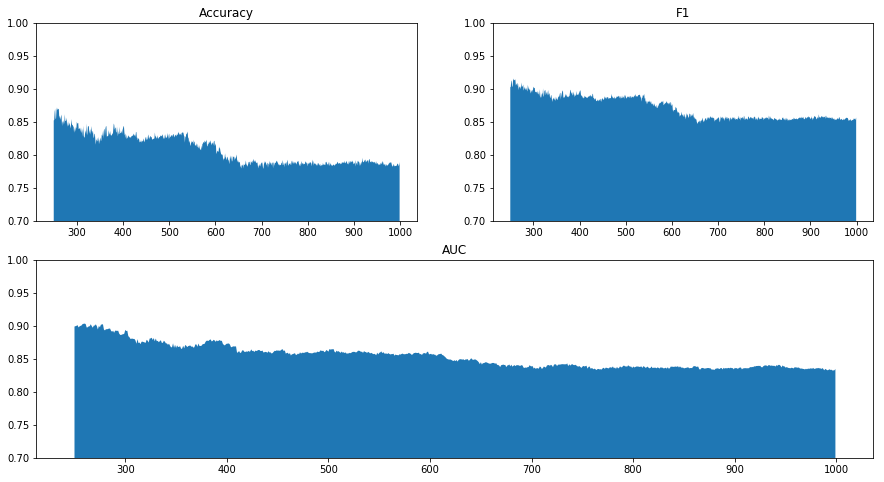

In [93]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(nrows=2, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.fill_between(orig_results.index, orig_results['Accuracy'], \
                 np.repeat(0, len(orig_results.index)))
ax0.set_title('Accuracy')
ax0.set_ylim(0.7, 1)

ax1 = fig.add_subplot(gs[0, 1])
ax1.fill_between(orig_results.index, orig_results['F1'], \
                 np.repeat(0, len(orig_results.index)))
ax1.set_title('F1')
ax1.set_ylim(0.7, 1)

ax2 = fig.add_subplot(gs[1, :])
ax2.fill_between(orig_results.index, orig_results['AUC'], \
                 np.repeat(0, len(orig_results.index)))
ax2.set_title('AUC')
ax2.set_ylim(0.7, 1)

plt.show()

In [251]:
orig_results.iloc[-1]

Target       1.000000
Pred         1.000000
Accuracy     0.788789
Precision    0.816883
Recall       0.899857
F1           0.856365
AUC          0.834716
Name: 999, dtype: float64

# Input detection

## kNN

In [108]:
knn_classes = []

for noise_prop in noise_props:
    in_knn_norm, in_knn_abnorm = train_detection(ts, 'knn', credit_cb, \
                                                 noise_prop=noise_prop)
    knn_classes.append((in_knn_norm, in_knn_abnorm))
    print_ratio(noise_prop, 'kNN', in_knn_norm, in_knn_abnorm)
    print()

kNN 
Noise: 0.050000, Normal: 935, Abnormal: 65, Ratio: 0.065000

kNN 
Noise: 0.100000, Normal: 852, Abnormal: 148, Ratio: 0.148000

kNN 
Noise: 0.200000, Normal: 695, Abnormal: 305, Ratio: 0.305000

kNN 
Noise: 0.500000, Normal: 311, Abnormal: 689, Ratio: 0.689000



## DBSCAN

In [109]:
dbscan_classes = []

for noise_prop in noise_props:
    in_dbscan_norm, in_dbscan_abnorm = train_detection(ts, 'dbscan', credit_cb, \
                                                       noise_prop=noise_prop)
    dbscan_classes.append((in_dbscan_norm, in_dbscan_abnorm))
    print_ratio(noise_prop, 'DBSCAN', in_dbscan_norm, in_dbscan_abnorm)
    print()

DBSCAN 
Noise: 0.050000, Normal: 958, Abnormal: 42, Ratio: 0.042000

DBSCAN 
Noise: 0.100000, Normal: 919, Abnormal: 81, Ratio: 0.081000

DBSCAN 
Noise: 0.200000, Normal: 813, Abnormal: 187, Ratio: 0.187000

DBSCAN 
Noise: 0.500000, Normal: 609, Abnormal: 391, Ratio: 0.391000



## Neural networks

### kNN

In [ ]:
nn_knn_classes = []

for i in range(len(noise_props)):
    nn_knn_in_norm, nn_knn_in_abnorm = \
    train_nn_detection(label_data(knn_classes[i][0], knn_classes[i][1]), credit_cb)
    nn_knn_classes.append((nn_knn_in_norm, nn_knn_in_abnorm))

In [198]:
for i in range(len(noise_props)):
    print_ratio(noise_props[i], 'NN-kNN', nn_knn_classes[i][0], nn_knn_classes[i][1])
    print()

NN-kNN 
Noise: 0.050000, Normal: 717, Abnormal: 283, Ratio: 0.283000

NN-kNN 
Noise: 0.100000, Normal: 603, Abnormal: 397, Ratio: 0.397000

NN-kNN 
Noise: 0.200000, Normal: 538, Abnormal: 462, Ratio: 0.462000

NN-kNN 
Noise: 0.500000, Normal: 78, Abnormal: 922, Ratio: 0.922000



### DBSCAN

In [ ]:
nn_dbscan_classes = []

for i in range(len(noise_props)):
    nn_dbscan_in_norm, nn_dbscan_in_abnorm = \
    train_nn_detection(label_data(dbscan_classes[i][0], dbscan_classes[i][1]), credit_cb)
    nn_dbscan_classes.append((nn_dbscan_in_norm, nn_dbscan_in_abnorm))

In [200]:
for i in range(len(noise_props)):
    print_ratio(noise_props[i], 'NN-DBSCAN', nn_dbscan_classes[i][0], \
                nn_dbscan_classes[i][1])
    print()

NN-DBSCAN 
Noise: 0.050000, Normal: 717, Abnormal: 283, Ratio: 0.283000

NN-DBSCAN 
Noise: 0.100000, Normal: 717, Abnormal: 283, Ratio: 0.283000

NN-DBSCAN 
Noise: 0.200000, Normal: 490, Abnormal: 510, Ratio: 0.510000

NN-DBSCAN 
Noise: 0.500000, Normal: 340, Abnormal: 660, Ratio: 0.660000



# Normal Training

## kNN

In [26]:
knn_results = []
for knn_class in knn_classes:
    knn_results.append(train_credit(LogisticRegression(), knn_class[0], 250))

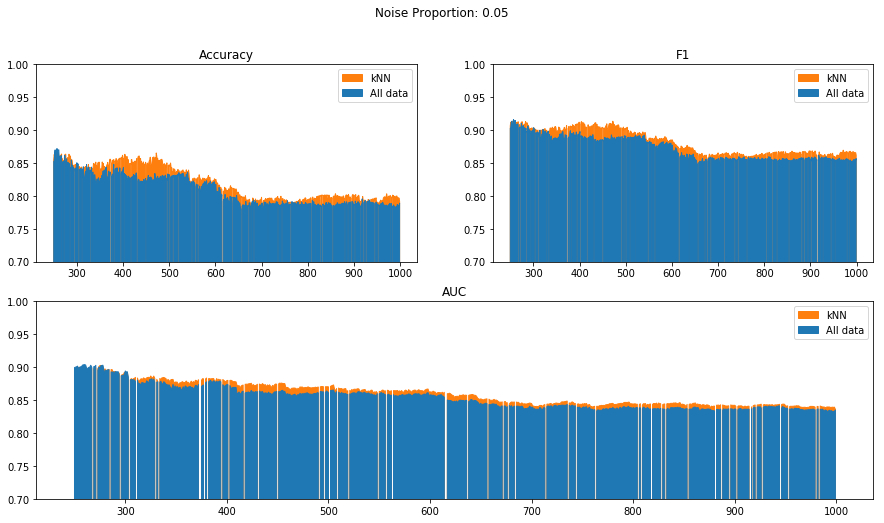

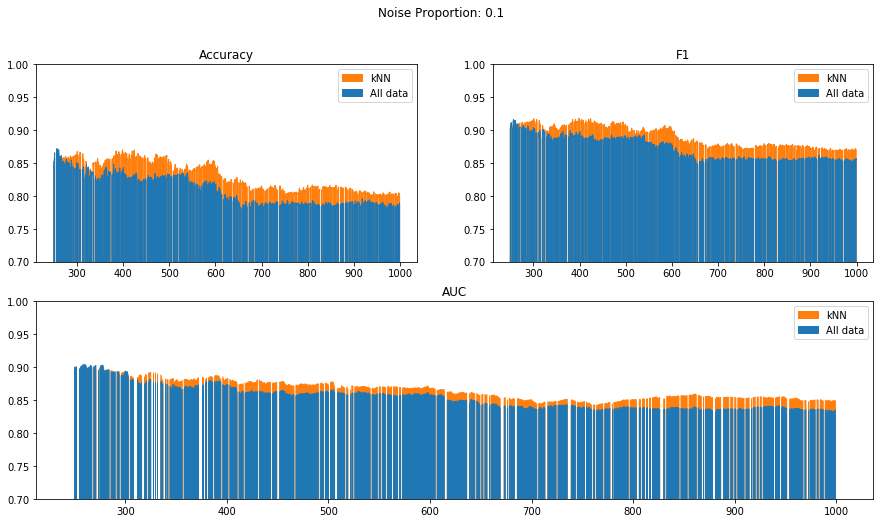

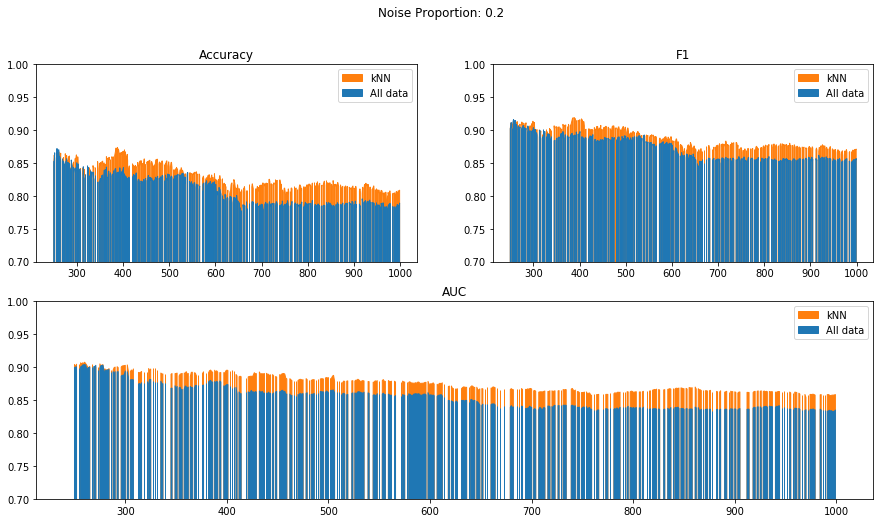

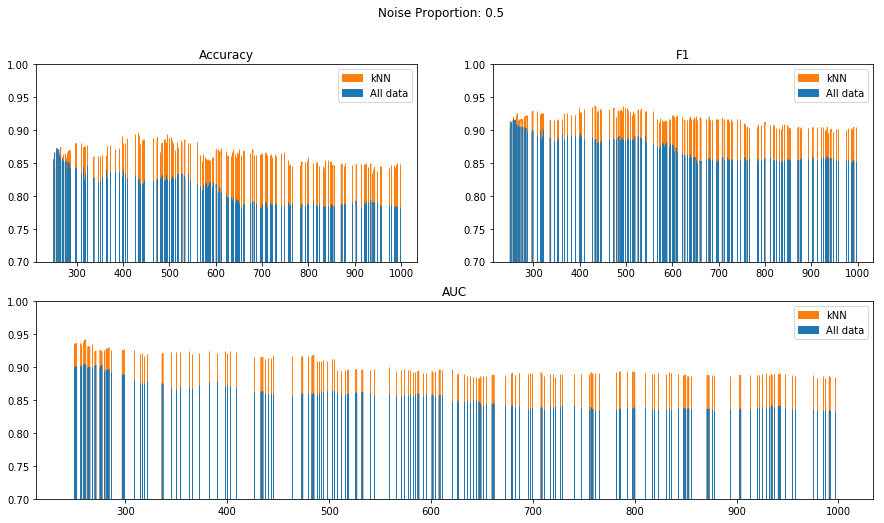

In [94]:
for i in range(len(knn_results)):
    plot_perf_new(knn_results[i], orig_results, 'kNN', noise_props[i])

In [257]:
for i in range(len(knn_results)):
    print('Noise: ', noise_props[i])
    print(knn_results[i].drop(labels=['Target', 'Pred'], axis=1).iloc[-1])
    print()

Noise:  0.05
Accuracy     0.791221
Precision    0.818059
Recall       0.910045
F1           0.861604
AUC          0.835762
Name: 999, dtype: float64

Noise:  0.1
Accuracy     0.801410
Precision    0.829161
Recall       0.913961
F1           0.869498
AUC          0.848922
Name: 999, dtype: float64

Noise:  0.2
Accuracy     0.808357
Precision    0.834264
Recall       0.910569
F1           0.870748
AUC          0.858156
Name: 999, dtype: float64

Noise:  0.5
Accuracy     0.848387
Precision    0.860465
Recall       0.952790
F1           0.904277
AUC          0.884510
Name: 997, dtype: float64



## DBSCAN

In [36]:
dbscan_results = []
for dbscan_class in dbscan_classes:
    dbscan_results.append(train_credit(LogisticRegression(), dbscan_class[0], 250))

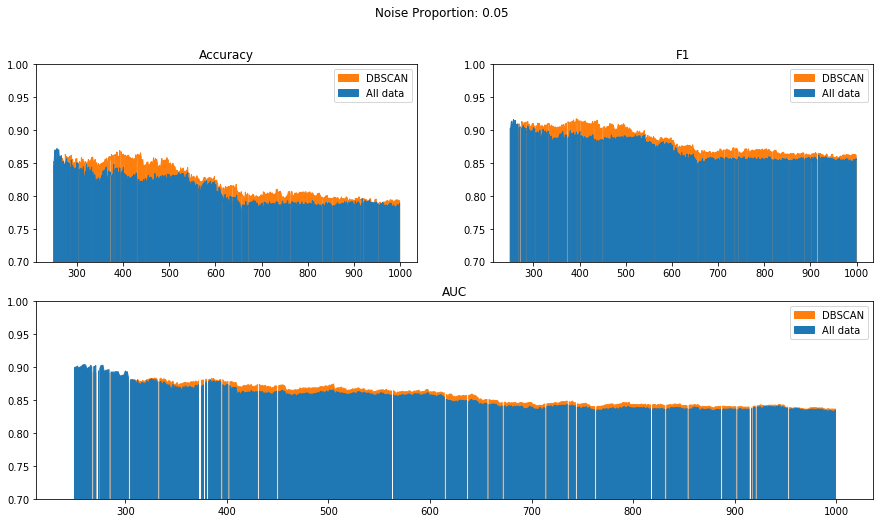

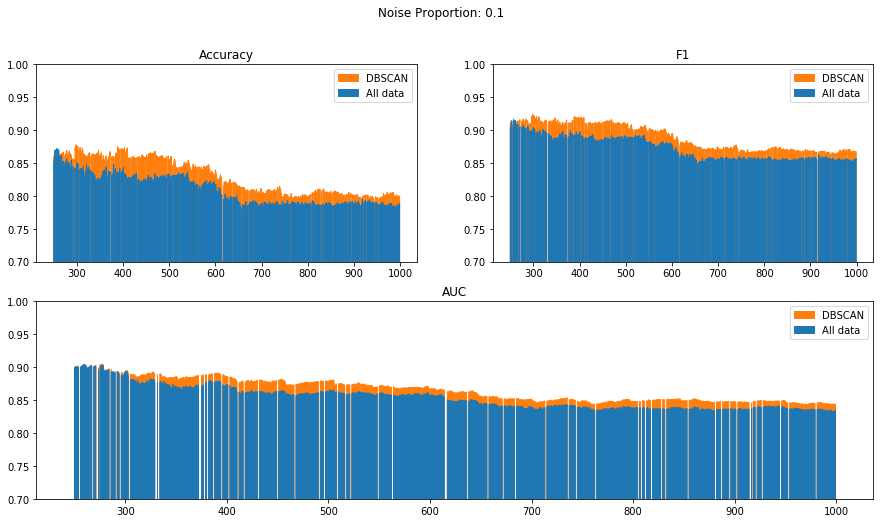

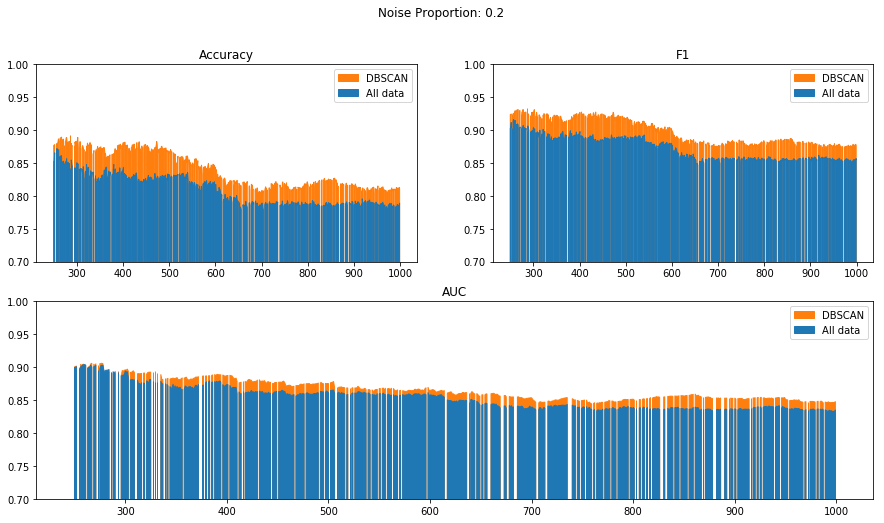

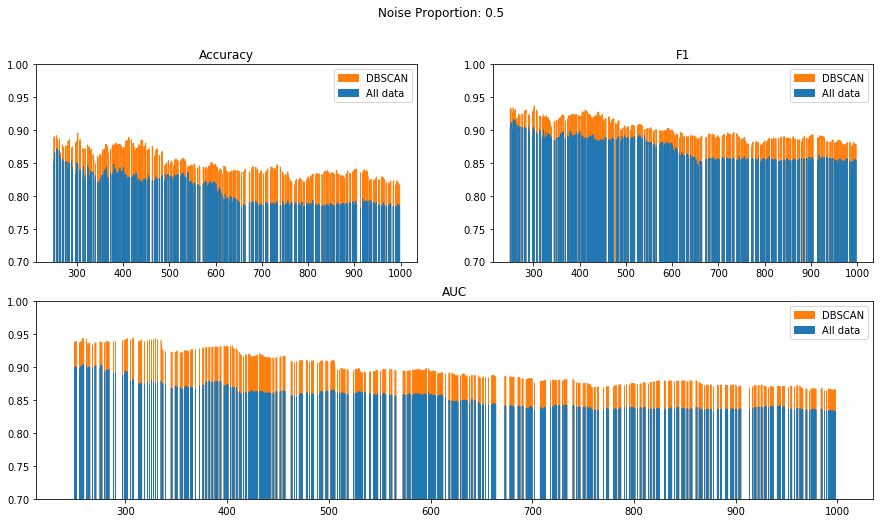

In [95]:
for i in range(len(dbscan_results)):
    plot_perf_new(dbscan_results[i], orig_results, 'DBSCAN', noise_props[i])

In [258]:
for i in range(len(dbscan_results)):
    print('Noise: ', noise_props[i])
    print(dbscan_results[i].drop(labels=['Target', 'Pred'], axis=1).iloc[-1])
    print()

Noise:  0.05
Accuracy     0.791014
Precision    0.817942
Recall       0.909091
F1           0.861111
AUC          0.836268
Name: 999, dtype: float64

Noise:  0.1
Accuracy     0.799564
Precision    0.828492
Recall       0.908953
F1           0.866860
AUC          0.843457
Name: 999, dtype: float64

Noise:  0.2
Accuracy     0.810345
Precision    0.836141
Recall       0.920742
F1           0.876404
AUC          0.847390
Name: 999, dtype: float64

Noise:  0.5
Accuracy     0.815789
Precision    0.840336
Recall       0.917431
F1           0.877193
AUC          0.865599
Name: 998, dtype: float64



## Neural networks

### kNN

In [201]:
nn_knn_results = []
for nn_knn_class in nn_knn_classes:
    nn_knn_results.append(train_credit(LogisticRegression(), nn_knn_class[0]\
                                       .drop(labels='abnorm', axis=1), 250))

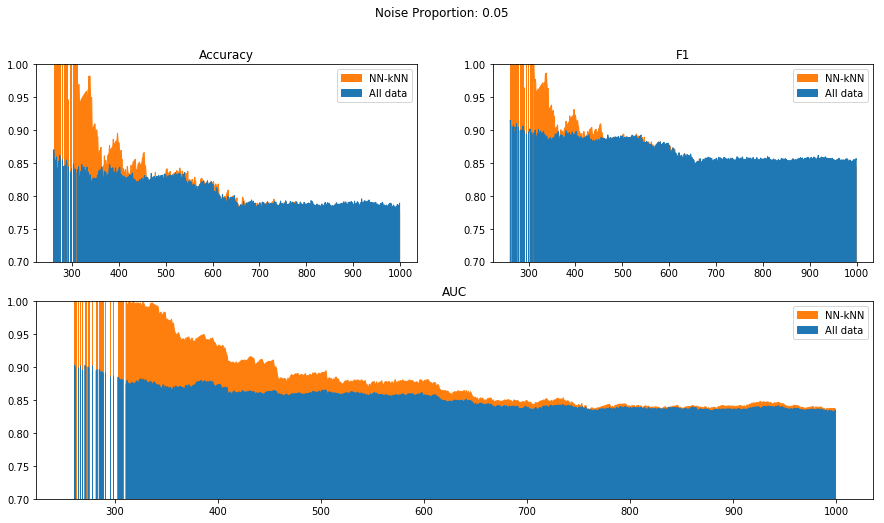

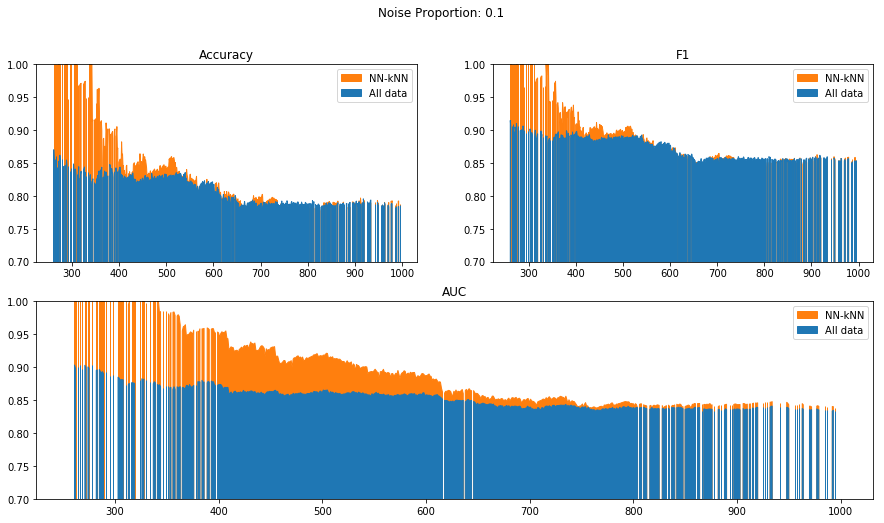

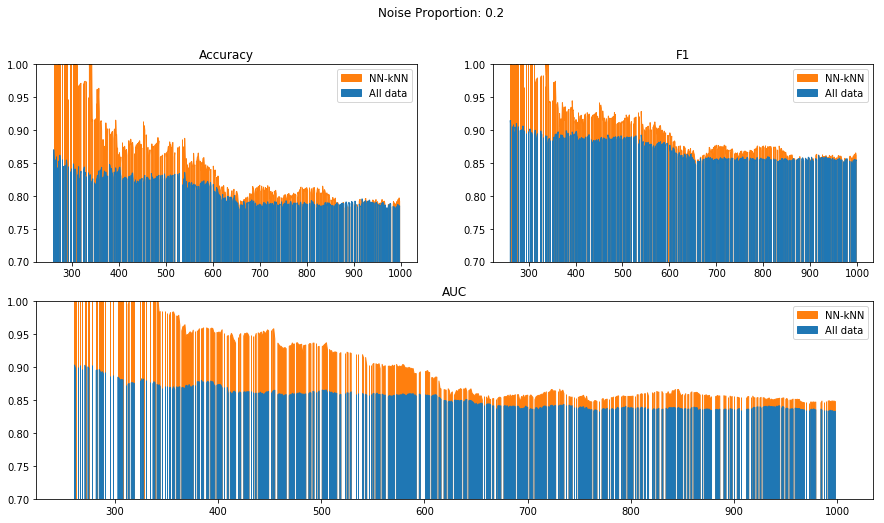

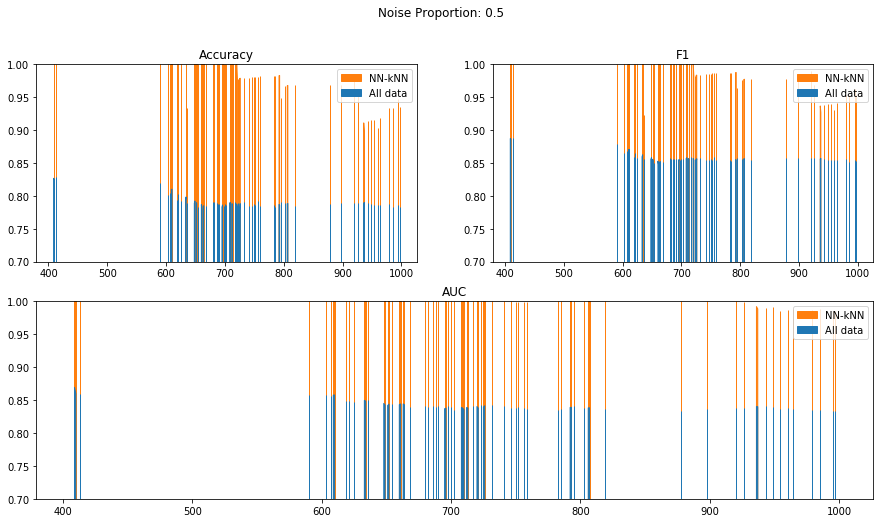

In [202]:
for i in range(len(nn_knn_results)):
    plot_perf_new(nn_knn_results[i], orig_results, 'NN-kNN', noise_props[i])

In [259]:
for i in range(len(nn_knn_results)):
    print('Noise: ', noise_props[i])
    print(nn_knn_results[i].drop(labels=['Target', 'Pred'], axis=1).iloc[-1])
    print()

Noise:  0.05
Accuracy     0.773743
Precision    0.804067
Recall       0.885947
F1           0.843023
AUC          0.836099
Name: 999, dtype: float64

Noise:  0.1
Accuracy     0.787375
Precision    0.810753
Recall       0.904077
F1           0.854875
AUC          0.837112
Name: 995, dtype: float64

Noise:  0.2
Accuracy     0.791434
Precision    0.816901
Recall       0.910995
F1           0.861386
AUC          0.847560
Name: 998, dtype: float64

Noise:  0.5
Accuracy     0.935065
Precision    0.944444
Recall       0.962264
F1           0.953271
AUC          0.985063
Name: 997, dtype: float64



### DBSCAN

In [218]:
nn_dbscan_results = []
for nn_dbscan_class in nn_dbscan_classes:
    nn_dbscan_results.append\
    (train_credit(LogisticRegression(), nn_dbscan_class[0]\
                  .drop(labels='abnorm', axis=1), 250))

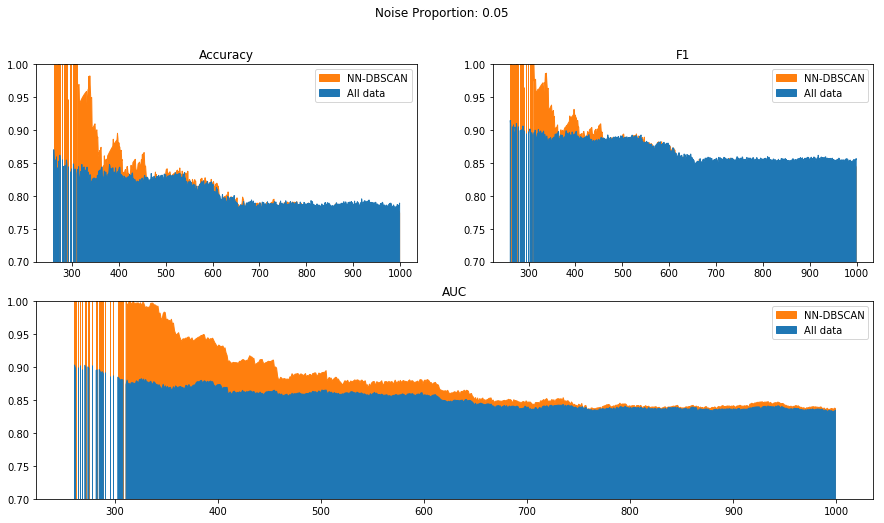

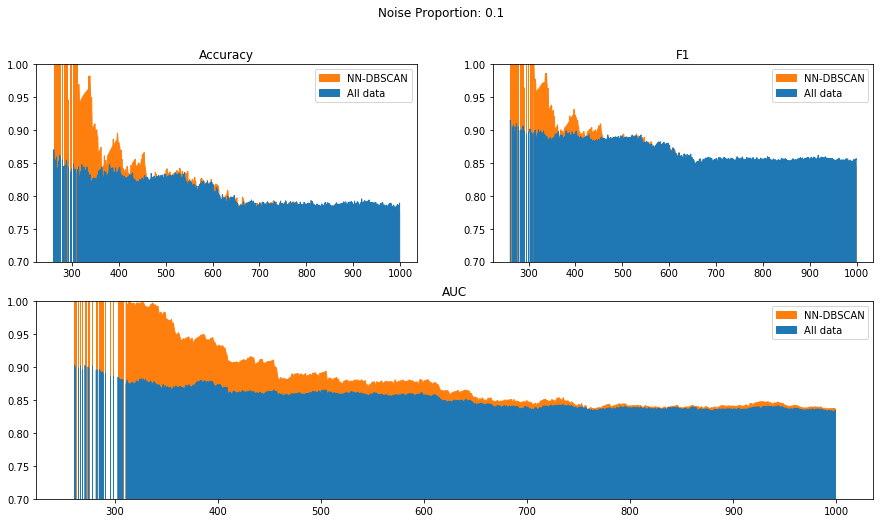

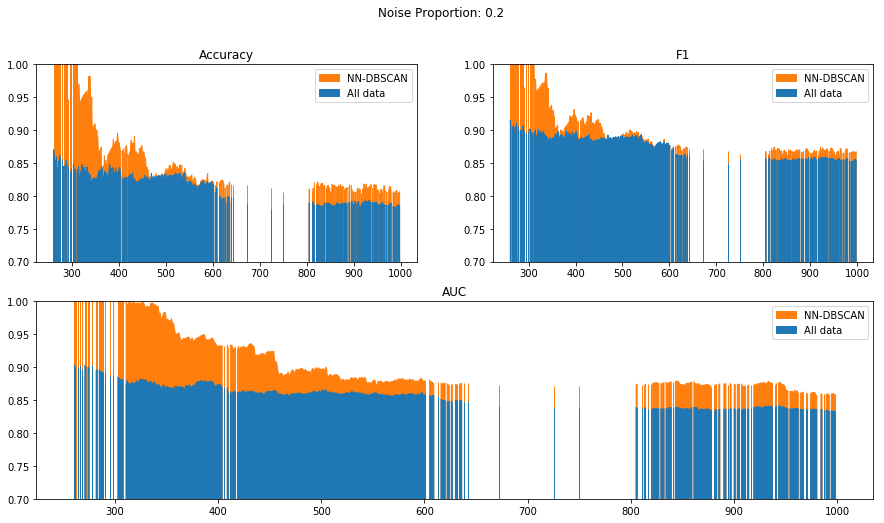

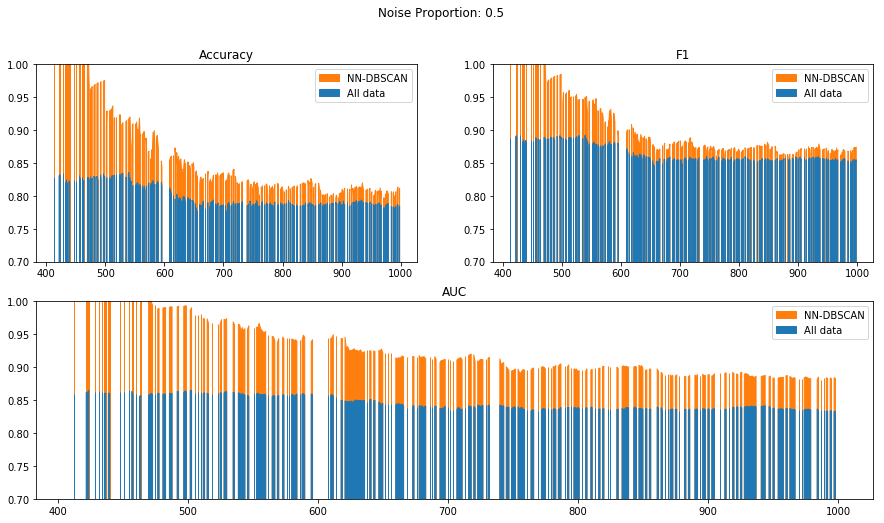

In [219]:
for i in range(len(nn_dbscan_results)):
    plot_perf_new(nn_dbscan_results[i], orig_results, 'NN-DBSCAN', noise_props[i])

In [260]:
for i in range(len(nn_dbscan_results)):
    print('Noise: ', noise_props[i])
    print(nn_dbscan_results[i].drop(labels=['Target', 'Pred'], axis=1).iloc[-1])
    print()

Noise:  0.05
Accuracy     0.773743
Precision    0.805195
Recall       0.883910
F1           0.842718
AUC          0.837103
Name: 999, dtype: float64

Noise:  0.1
Accuracy     0.773743
Precision    0.804067
Recall       0.885947
F1           0.843023
AUC          0.836099
Name: 999, dtype: float64

Noise:  0.2
Accuracy     0.805726
Precision    0.821809
Recall       0.916914
F1           0.866760
AUC          0.858074
Name: 998, dtype: float64

Noise:  0.5
Accuracy     0.811209
Precision    0.833962
Recall       0.917012
F1           0.873518
AUC          0.882632
Name: 998, dtype: float64



# Delayed Feedback

## Original

In [ ]:
orig_results_batch = train_credit(LogisticRegression(), ts, 250, test_size=50)

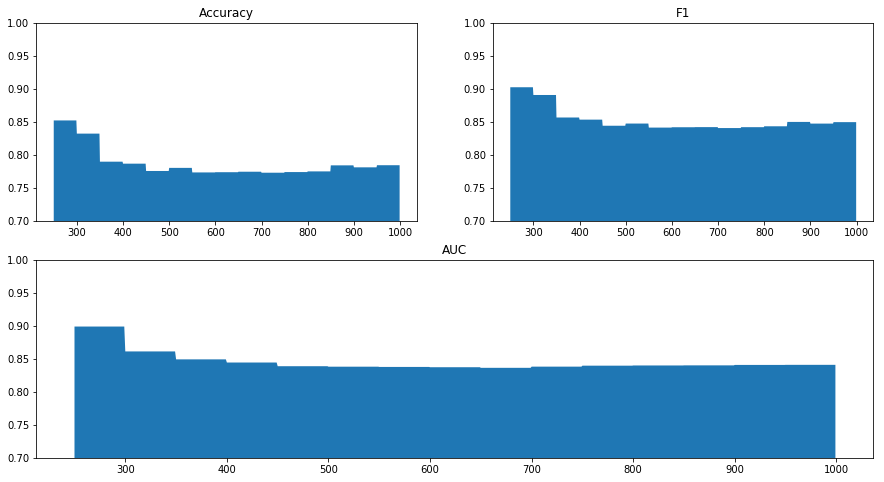

In [176]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(nrows=2, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.fill_between(orig_results_batch.index, orig_results_batch['Accuracy'], \
                 np.repeat(0, len(orig_results_batch.index)))
ax0.set_title('Accuracy')
ax0.set_ylim(0.7, 1)

ax1 = fig.add_subplot(gs[0, 1])
ax1.fill_between(orig_results_batch.index, orig_results_batch['F1'], \
                 np.repeat(0, len(orig_results_batch.index)))
ax1.set_title('F1')
ax1.set_ylim(0.7, 1)

ax2 = fig.add_subplot(gs[1, :])
ax2.fill_between(orig_results_batch.index, orig_results_batch['AUC'], \
                 np.repeat(0, len(orig_results_batch.index)))
ax2.set_title('AUC')
ax2.set_ylim(0.7, 1)

plt.show()

In [261]:
orig_results_batch.iloc[-1]

Target       1.000000
Pred         1.000000
Accuracy     0.784040
Precision    0.815747
Recall       0.885983
F1           0.849415
AUC          0.841090
Name: 999, dtype: float64

## kNN

In [ ]:
knn_results_batch = []
for knn_class in knn_classes:
    knn_results_batch.append(train_credit(LogisticRegression(), \
                                          knn_class[0], 250, test_size=50))

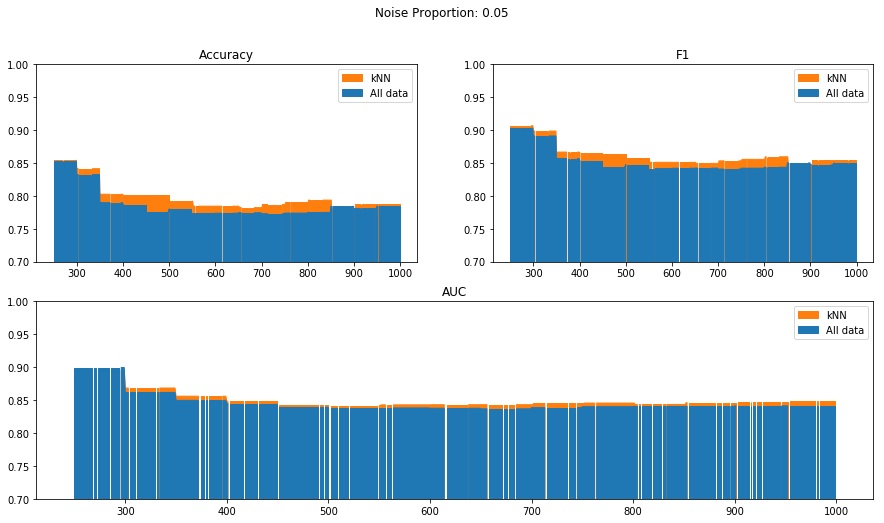

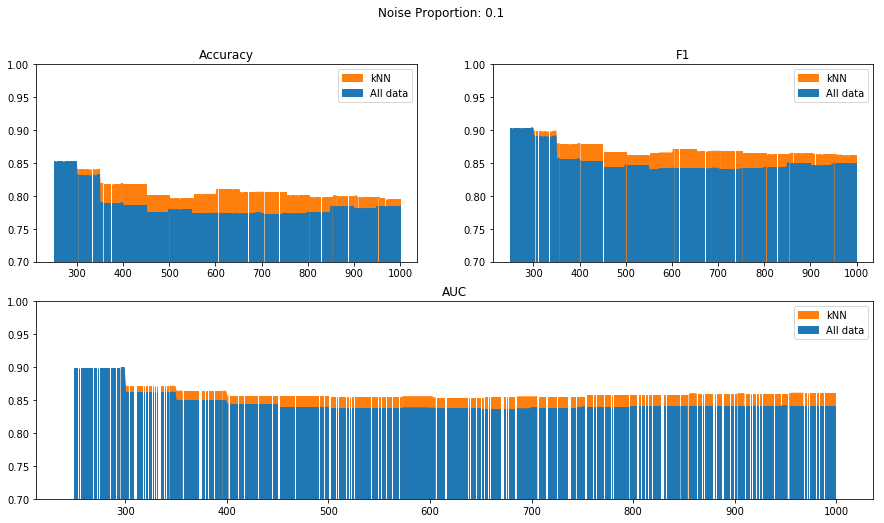

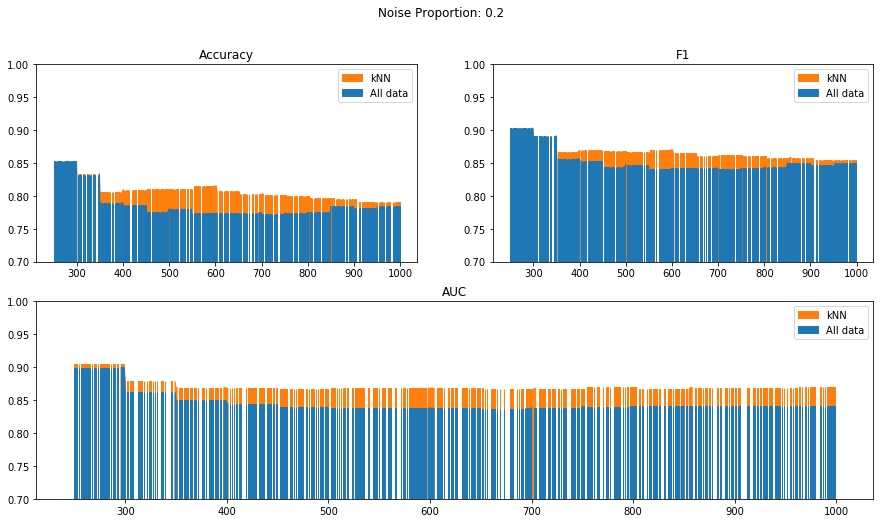

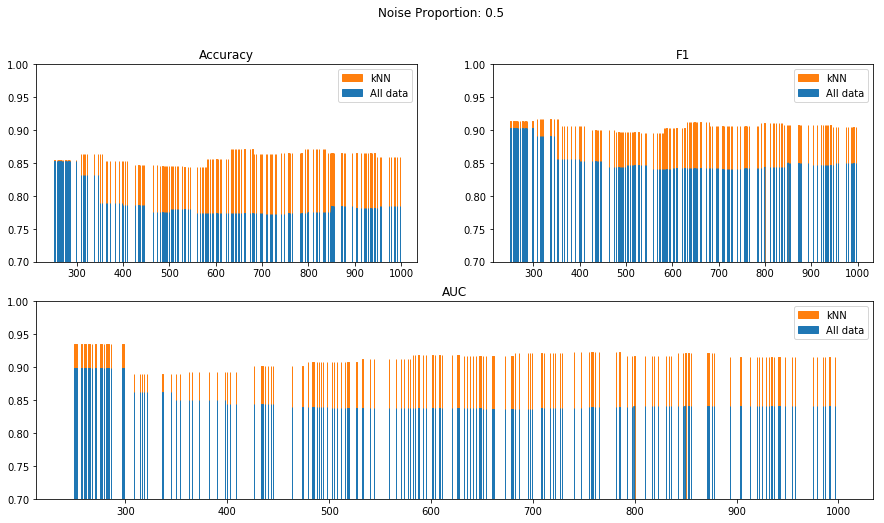

In [178]:
for i in range(len(knn_results_batch)):
    plot_perf_new(knn_results_batch[i], orig_results_batch, 'kNN', noise_props[i])

In [263]:
for i in range(len(knn_results_batch)):
    print('Noise: ', noise_props[i])
    print(knn_results_batch[i].drop(\
            labels=['Target', 'Pred', 'Precision', 'Recall'], axis=1).iloc[-1])
    print()

Noise:  0.05
Accuracy    0.787939
F1          0.854783
AUC         0.847679
Name: 999, dtype: float64

Noise:  0.1
Accuracy    0.795741
F1          0.861503
AUC         0.860234
Name: 999, dtype: float64

Noise:  0.2
Accuracy    0.790663
F1          0.854785
AUC         0.869688
Name: 999, dtype: float64

Noise:  0.5
Accuracy    0.859114
F1          0.903674
AUC         0.915771
Name: 997, dtype: float64



## DBSCAN

In [102]:
dbscan_results_batch = []
for dbscan_class in dbscan_classes:
    dbscan_results_batch.append(train_credit(LogisticRegression(), \
                                             dbscan_class[0], 250, test_size=50))

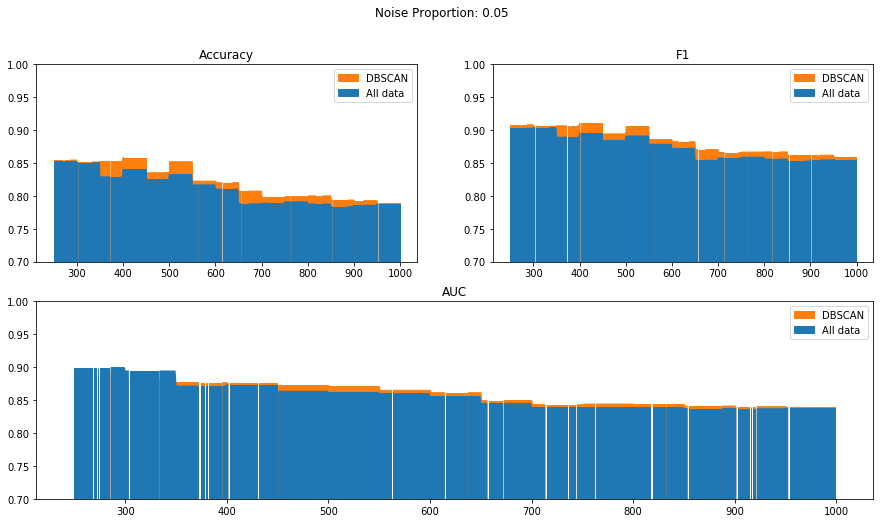

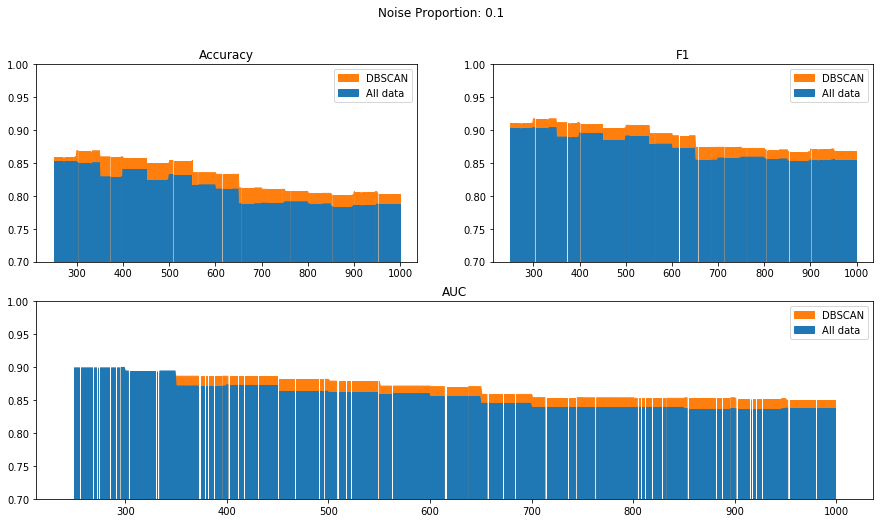

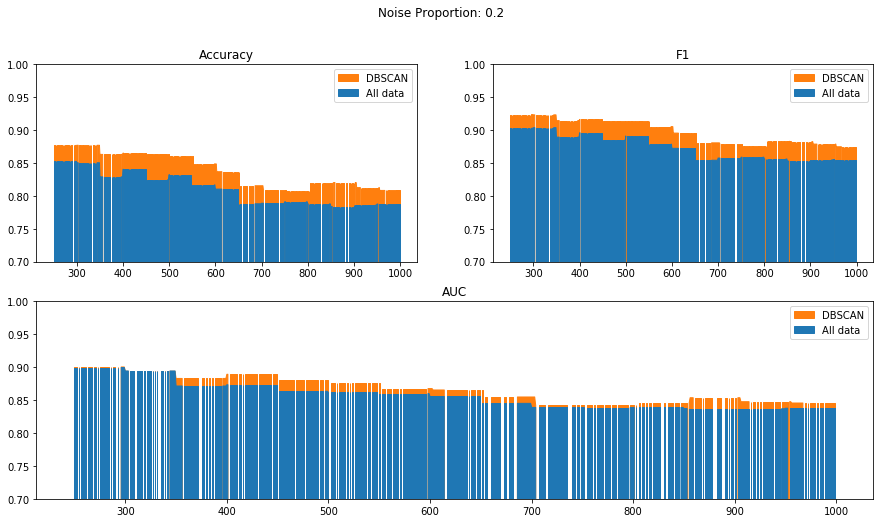

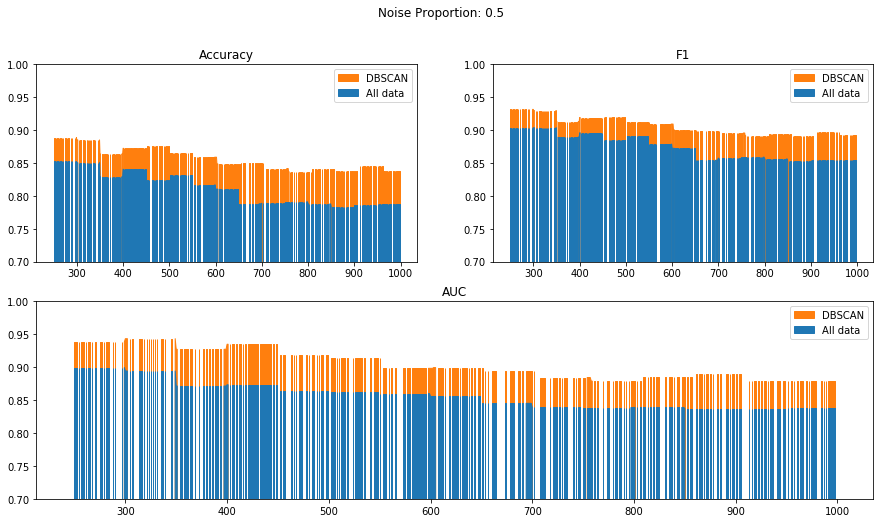

In [103]:
for i in range(len(dbscan_results_batch)):
    plot_perf_new(dbscan_results_batch[i], orig_results_batch, \
                  'DBSCAN', noise_props[i])

In [264]:
for i in range(len(dbscan_results_batch)):
    print('Noise: ', noise_props[i])
    print(dbscan_results_batch[i].drop(\
            labels=['Target', 'Pred', 'Precision', 'Recall'], axis=1).iloc[-1])
    print()

Noise:  0.05
Accuracy    0.788337
F1          0.858586
AUC         0.838792
Name: 999, dtype: float64

Noise:  0.1
Accuracy    0.802526
F1          0.868098
AUC         0.849421
Name: 999, dtype: float64

Noise:  0.2
Accuracy    0.807990
F1          0.874262
AUC         0.845389
Name: 999, dtype: float64

Noise:  0.5
Accuracy    0.837413
F1          0.891735
AUC         0.879166
Name: 998, dtype: float64



## Neural networks

### kNN

In [220]:
nn_knn_results_batch = []
for nn_knn_class in nn_knn_classes:
    nn_knn_results_batch.append\
    (train_credit(LogisticRegression(), \
                  nn_knn_class[0].drop(labels='abnorm', axis=1), 250, test_size=50))

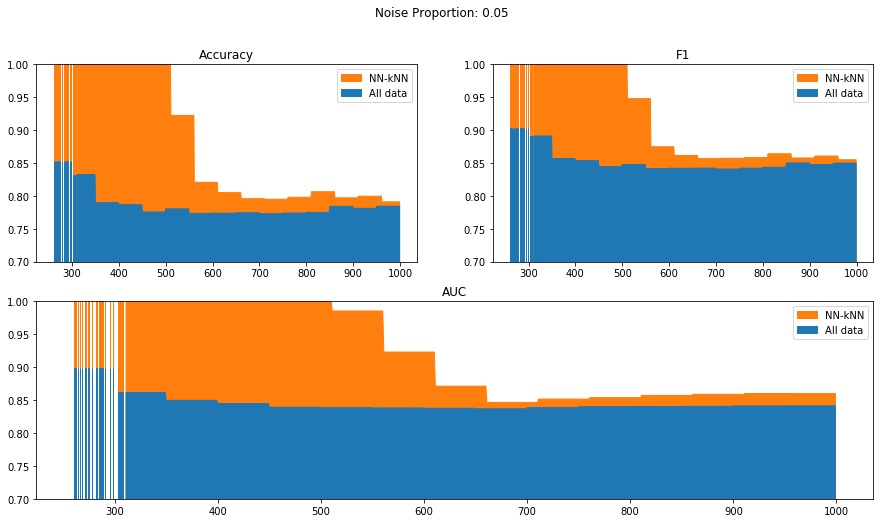

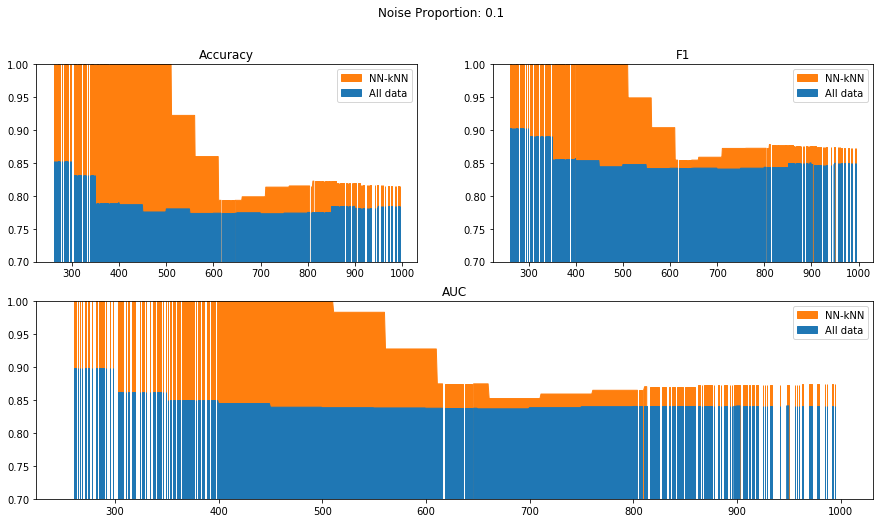

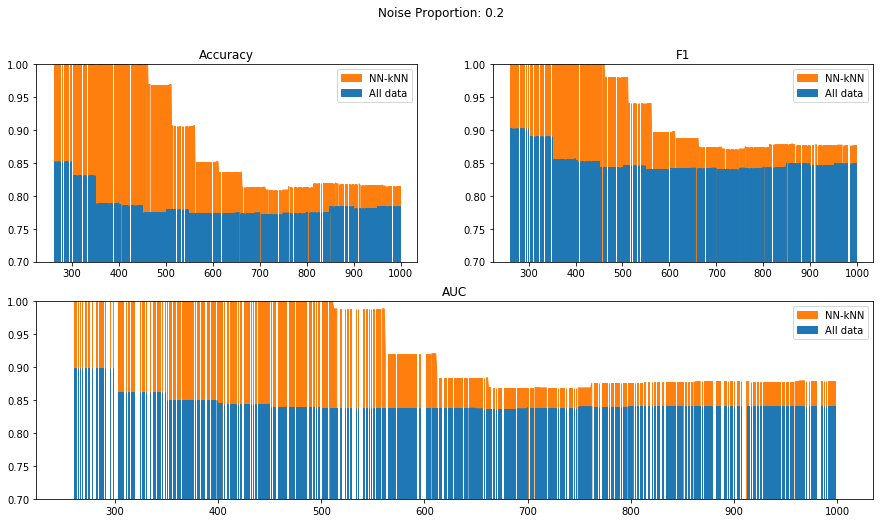

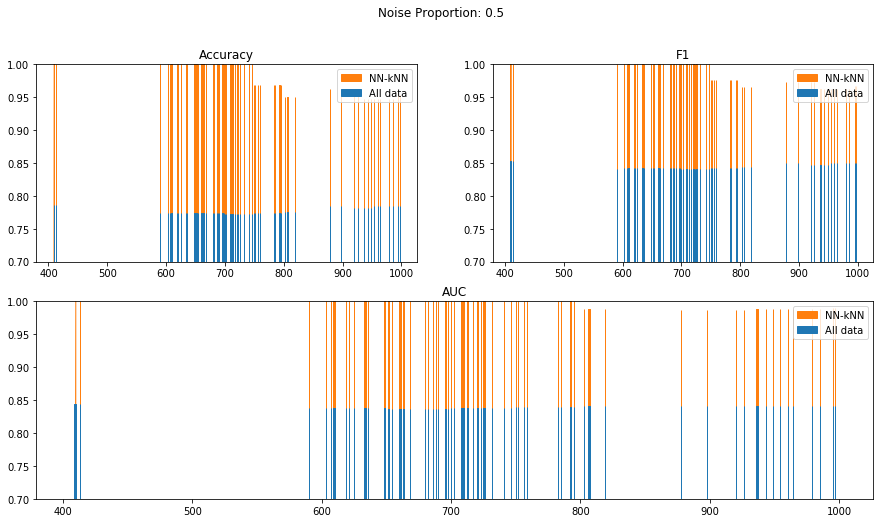

In [221]:
for i in range(len(nn_knn_results_batch)):
    plot_perf_new(nn_knn_results_batch[i], \
                  orig_results_batch, 'NN-kNN', noise_props[i])

In [265]:
for i in range(len(nn_knn_results_batch)):
    print('Noise: ', noise_props[i])
    print(nn_knn_results_batch[i].drop(\
            labels=['Target', 'Pred', 'Precision', 'Recall'], axis=1).iloc[-1])
    print()

Noise:  0.05
Accuracy    0.790724
F1          0.854560
AUC         0.859680
Name: 999, dtype: float64

Noise:  0.1
Accuracy    0.815408
F1          0.872766
AUC         0.873479
Name: 995, dtype: float64

Noise:  0.2
Accuracy    0.814551
F1          0.876777
AUC         0.878989
Name: 998, dtype: float64

Noise:  0.5
Accuracy    0.952381
F1          0.966443
AUC         0.989974
Name: 997, dtype: float64



### DBSCAN

In [222]:
nn_dbscan_results_batch = []
for nn_dbscan_class in nn_dbscan_classes:
    nn_dbscan_results_batch.append\
    (train_credit(LogisticRegression(), \
                  nn_dbscan_class[0].drop(labels='abnorm', axis=1), 250, test_size=50))

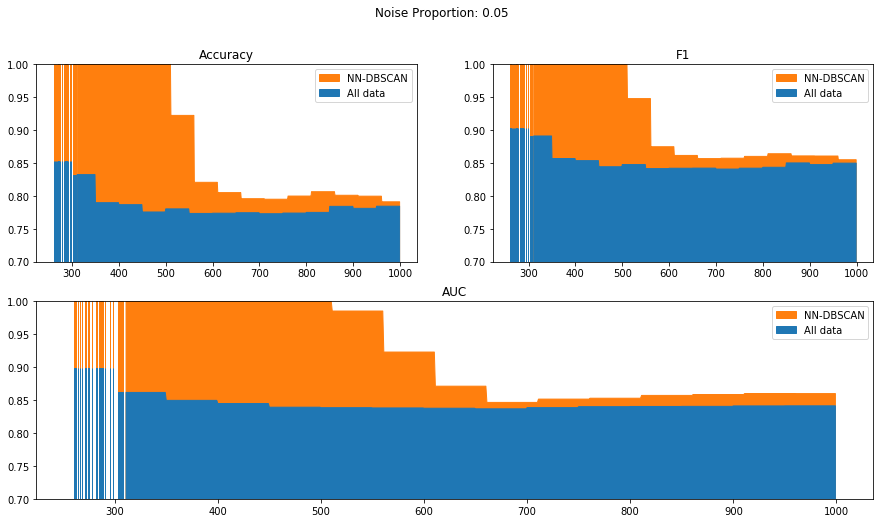

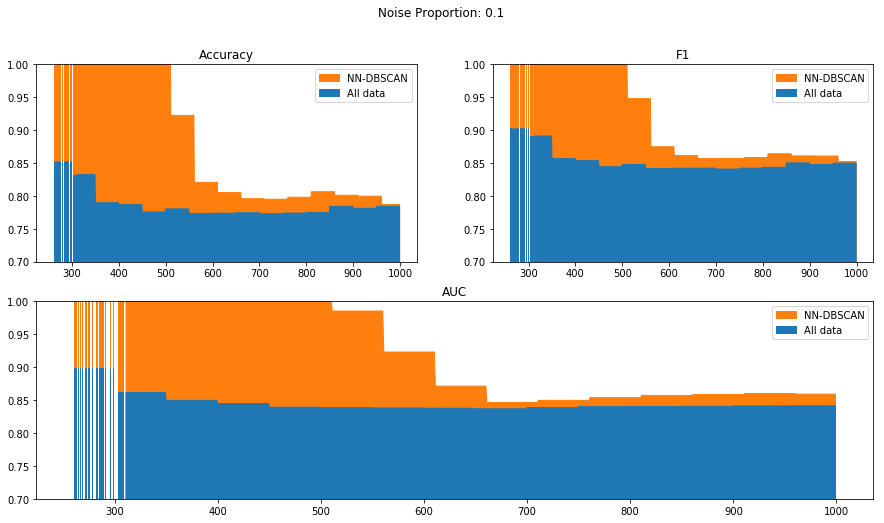

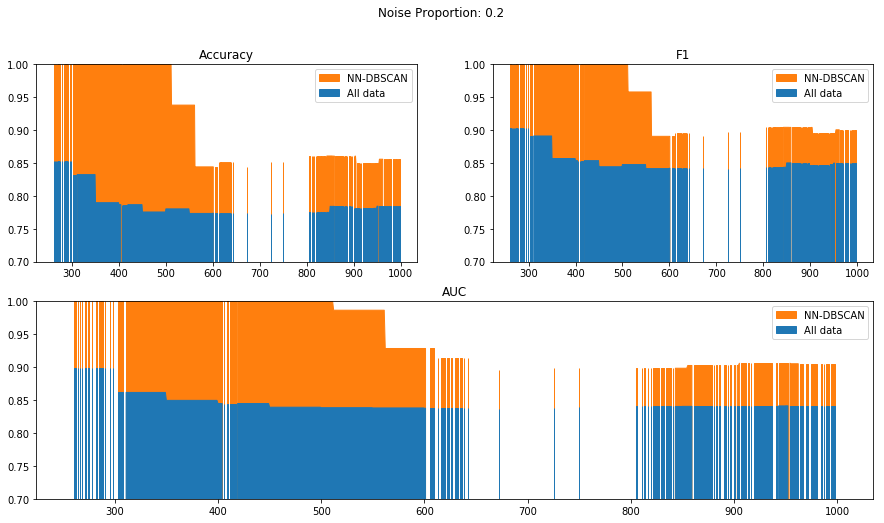

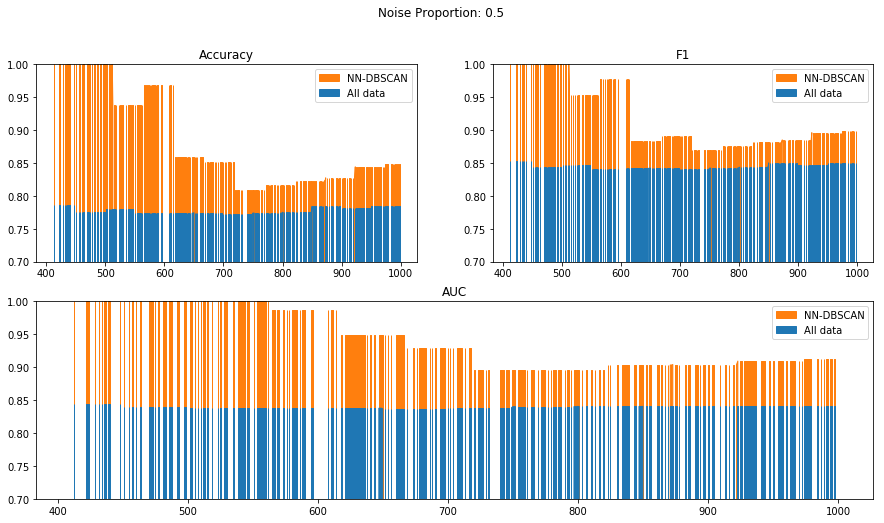

In [223]:
for i in range(len(nn_dbscan_results_batch)):
    plot_perf_new(nn_dbscan_results_batch[i], \
                  orig_results_batch, 'NN-DBSCAN', noise_props[i])

In [268]:
for i in range(len(nn_dbscan_results_batch)):
    print('Noise: ', noise_props[i])
    print(nn_dbscan_results_batch[i].drop(\
            labels=['Target', 'Pred', 'Precision', 'Recall'], axis=1).iloc[-1])
    print()

Noise:  0.05
Accuracy    0.790724
F1          0.854560
AUC         0.859683
Name: 999, dtype: float64

Noise:  0.1
Accuracy    0.786765
F1          0.851983
AUC         0.858842
Name: 999, dtype: float64

Noise:  0.2
Accuracy    0.855399
F1          0.900000
AUC         0.904973
Name: 998, dtype: float64

Noise:  0.5
Accuracy    0.848750
F1          0.898745
AUC         0.912316
Name: 998, dtype: float64



# Output Detection

## kNN

In [ ]:
print_stats('Orig', orig_results, None)

In [104]:
out_knn_classes = []
for noise_prop in [0.02] + noise_props:
    out_knn_classes.append(train_detection(orig_results, 'knn', \
                                           credit_cb, noise_prop=noise_prop))

In [291]:
for i in range(len(out_knn_classes)):
    out_knn_norm = out_knn_classes[i][0]
    out_knn_abnorm = out_knn_classes[i][1]
    print_ratio(([0.02] + noise_props)[i], 'kNN', out_knn_norm, out_knn_abnorm)
    print_stats('kNN', out_knn_norm, out_knn_abnorm)
    print()

kNN 
Noise: 0.020000, Normal: 338, Abnormal: 412, Ratio: 0.549333
kNN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.830936	0.889117	0.869519	0.760355	0.842718
Abnormal	0.789326	0.856651	0.840453	0.742718	0.817241

kNN 
Noise: 0.050000, Normal: 319, Abnormal: 431, Ratio: 0.574667
kNN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.831229	0.889358	0.869590	0.774295	0.856574
Abnormal	0.790943	0.857904	0.841681	0.733179	0.806071

kNN 
Noise: 0.100000, Normal: 296, Abnormal: 454, Ratio: 0.605333
kNN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.831269	0.889442	0.869459	0.790541	0.869748
Abnormal	0.792958	0.859443	0.843180	0.724670	0.798061

kNN 
Noise: 0.200000, Normal: 251, Abnormal: 499, Ratio: 0.665333
kNN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.831377	0.889588	0.869156	0.824701	0.894737
Abnormal	0.796358	0.862074	0.845703	0.713427	0.788774

kNN 
Noise: 0.500000, Normal: 152, Abnormal: 598, Ratio: 0.797333
kNN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.830928	0.889269	0.867469	0.894737	0.942446


## DBSCAN

In [106]:
out_dbscan_classes = []
for noise_prop in [0.02] + noise_props:
    out_dbscan_classes.append(train_detection(orig_results, 'dbscan', \
                                              credit_cb, noise_prop=noise_prop))

In [295]:
for i in range(len(out_dbscan_classes)):
    out_dbscan_norm = out_dbscan_classes[i][0]
    out_dbscan_abnorm = out_dbscan_classes[i][1]
    print_ratio(([0.02]+noise_props)[i], 'DBSCAN', out_dbscan_norm, \
                out_dbscan_abnorm)
    print_stats('DBSCAN', out_dbscan_norm, out_dbscan_abnorm)
    print()

DBSCAN 
Noise: 0.020000, Normal: 628, Abnormal: 122, Ratio: 0.162667
DBSCAN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.811197	0.873797	0.855444	0.866242	0.913402
Abnormal	0.792026	0.858339	0.843810	0.155738	0.176000

DBSCAN 
Noise: 0.050000, Normal: 556, Abnormal: 194, Ratio: 0.258667
DBSCAN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.813217	0.875357	0.856613	0.861511	0.919540
Abnormal	0.793351	0.859605	0.844777	0.432990	0.202899

DBSCAN 
Noise: 0.100000, Normal: 524, Abnormal: 226, Ratio: 0.301333
DBSCAN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.813273	0.875480	0.856310	0.872137	0.926293
Abnormal	0.796034	0.861550	0.847157	0.469027	0.354839

DBSCAN 
Noise: 0.200000, Normal: 289, Abnormal: 461, Ratio: 0.614667
DBSCAN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.830051	0.888464	0.867988	0.813149	0.887967
Abnormal	0.794303	0.860511	0.844502	0.711497	0.783034

DBSCAN 
Noise: 0.500000, Normal: 172, Abnormal: 578, Ratio: 0.770667
DBSCAN		Accuracy	F1		AUC		Accuracy^	F1^
Normal		0.828027	0.8871

## Neural networks

### kNN

In [ ]:
out_nn_knn_classes = []
for i in range(len([0.02] + noise_props)):
    out_nn_knn_classes.append\
    (train_nn_detection(label_data(out_knn_classes[i][0], out_knn_classes[i][1]), credit_cb))

In [225]:
for i in range(len(out_nn_knn_classes)):
    out_nn_knn_norm = out_nn_knn_classes[i][0]
    out_nn_knn_abnorm = out_nn_knn_classes[i][1]
    print_ratio(([0.02] + noise_props)[i], 'NN-kNN', out_nn_knn_norm, \
                out_nn_knn_abnorm)
    print_stats('NN-kNN', out_nn_knn_norm, out_nn_knn_abnorm)
    print()

NN-kNN 
Noise: 0.020000, Normal: 667, Abnormal: 83, Ratio: 0.110667
NN-kNN		Accuracy	Precision	Recall		F1
Normal		0.749625	0.775895	0.895652	0.831483	
Abnormal	0.759036	0.954545	0.700000	0.807692	

NN-kNN 
Noise: 0.050000, Normal: 642, Abnormal: 108, Ratio: 0.144000
NN-kNN		Accuracy	Precision	Recall		F1
Normal		0.757009	0.786116	0.908894	0.843058	
Abnormal	0.712963	0.833333	0.593220	0.693069	

NN-kNN 
Noise: 0.100000, Normal: 598, Abnormal: 152, Ratio: 0.202667
NN-kNN		Accuracy	Precision	Recall		F1
Normal		0.760870	0.794059	0.911364	0.848677	
Abnormal	0.710526	0.757143	0.662500	0.706667	

NN-kNN 
Noise: 0.200000, Normal: 481, Abnormal: 269, Ratio: 0.358667
NN-kNN		Accuracy	Precision	Recall		F1
Normal		0.769231	0.817372	0.926768	0.868639	
Abnormal	0.717472	0.690476	0.701613	0.696000	

NN-kNN 
Noise: 0.500000, Normal: 252, Abnormal: 498, Ratio: 0.664000
NN-kNN		Accuracy	Precision	Recall		F1
Normal		1.000000	1.000000	1.000000	1.000000	
Abnormal	0.624498	0.625387	0.753731	0.683587	



### DBSCAN

In [ ]:
out_nn_dbscan_classes = []
for i in range(len([0.02] + noise_props)):
    out_nn_dbscan_classes.append\
    (train_nn_detection(label_data(out_dbscan_classes[i][0], \
                                   out_dbscan_classes[i][1]), credit_cb))

In [228]:
for i in range(len(out_nn_dbscan_classes)):
    out_nn_dbscan_norm = out_nn_dbscan_classes[i][0]
    out_nn_dbscan_abnorm = out_nn_dbscan_classes[i][1]
    print_ratio(([0.02]+noise_props)[i], 'NN-DBSCAN', \
                out_nn_dbscan_norm, out_nn_dbscan_abnorm)
    print_stats('NN-DBSCAN', out_nn_dbscan_norm, out_nn_dbscan_abnorm)
    print()

NN-DBSCAN 
Noise: 0.020000, Normal: 734, Abnormal: 16, Ratio: 0.021333
NN-DBSCAN		Accuracy	Precision	Recall		F1
Normal		0.767030	0.789565	0.900794	0.841520	
Abnormal	0.000000	0.000000	0.000000	0.000000	

NN-DBSCAN 
Noise: 0.050000, Normal: 692, Abnormal: 58, Ratio: 0.077333
NN-DBSCAN		Accuracy	Precision	Recall		F1
Normal		0.765896	0.789565	0.917172	0.848598	
Abnormal	0.568966	0.000000	0.000000	0.000000	

NN-DBSCAN 
Noise: 0.100000, Normal: 677, Abnormal: 73, Ratio: 0.097333
NN-DBSCAN		Accuracy	Precision	Recall		F1
Normal		0.760709	0.789565	0.917172	0.848598	
Abnormal	0.657534	0.000000	0.000000	0.000000	

NN-DBSCAN 
Noise: 0.200000, Normal: 551, Abnormal: 199, Ratio: 0.265333
NN-DBSCAN		Accuracy	Precision	Recall		F1
Normal		0.764065	0.806950	0.933036	0.865424	
Abnormal	0.713568	0.631579	0.500000	0.558140	

NN-DBSCAN 
Noise: 0.500000, Normal: 261, Abnormal: 489, Ratio: 0.652000
NN-DBSCAN		Accuracy	Precision	Recall		F1
Normal		1.000000	1.000000	1.000000	1.000000	
Abnormal	0.617587	0.61465

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Gender analysis

In [20]:
def split_gender(in_data, results):
    women = in_data.loc[ts['Personal status and sex_A92'] == 1]
    women_results = pd.DataFrame()
    men_results = pd.DataFrame()
    for i in results.index:
        # orig_results because we need samples we have metrics for
        if i in women.index:
            women_results = women_results.append(results.iloc[find_index(results, i)])
        else:
            men_results = men_results.append(results.iloc[find_index(results, i)])
    return women_results, men_results

In [231]:
def get_gender_split(df):
    women = df.loc[df['Personal status and sex_A92'] == 1]
    men = df.loc[df['Personal status and sex_A92'] != 1]
    return women, men

In [230]:
def print_gender_abnormality(method, classes):
    print('%s: ' % method)
    for i in range(len(noise_props)):
        women_norm, men_norm = get_gender_split(classes[i][0])
        women_abnorm, men_abnorm = get_gender_split(classes[i][1])
        print('Percentage of women deemed abnormal: ', \
              len(women_abnorm) / (len(women_abnorm) + len(women_norm)))
        print('Percentage of men deemed abnormal: ', \
              len(men_abnorm) / (len(men_abnorm) + len(men_norm)))
        print()

## TPR and FPR

### Original

In [21]:
women_results, men_results = split_gender(ts, orig_results)

In [22]:
assert len(women_results) + len(men_results) == len(orig_results)

In [239]:
tpr, fpr = tpr_fpr_calc(women_results)
print('Women:')
print('True Positive Rate: ', tpr)
print('False Positive Rate: ', fpr)

tpr, fpr = tpr_fpr_calc(men_results)
print('Men:')
print('True Positive Rate: ', tpr)
print('False Positive Rate: ', fpr)

Women:
True Positive Rate:  0.8129032258064516
False Positive Rate:  0.3411764705882353
Men:
True Positive Rate:  0.8986301369863013
False Positive Rate:  0.25517241379310346


### kNN

In [238]:
for i in range(len(noise_props)):
    print('Noise: ', noise_props[i])
    knn_women_results, knn_men_results = \
    split_gender(knn_classes[i][0], knn_results[i])
    tpr, fpr = tpr_fpr_calc(knn_women_results)
    print('Women:')
    print('True Positive Rate: ', tpr)
    print('False Positive Rate: ', fpr)
    tpr, fpr = tpr_fpr_calc(knn_men_results)
    print('Men:')
    print('True Positive Rate: ', tpr)
    print('False Positive Rate: ', fpr)
    print()

Noise:  0.05
Women:
True Positive Rate:  0.8092105263157895
False Positive Rate:  0.3815789473684211
Men:
True Positive Rate:  0.906158357771261
False Positive Rate:  0.25196850393700787

Noise:  0.1
Women:
True Positive Rate:  0.8345323741007195
False Positive Rate:  0.3333333333333333
Men:
True Positive Rate:  0.9061488673139159
False Positive Rate:  0.27102803738317754

Noise:  0.2
Women:
True Positive Rate:  0.8392857142857143
False Positive Rate:  0.2857142857142857
Men:
True Positive Rate:  0.9051724137931034
False Positive Rate:  0.25287356321839083

Noise:  0.5
Women:
True Positive Rate:  0.9
False Positive Rate:  0.2222222222222222
Men:
True Positive Rate:  0.9270833333333334
False Positive Rate:  0.21212121212121213



### DBSCAN

In [240]:
for i in range(len(noise_props)):
    print('Noise: ', noise_props[i])
    dbscan_women_results, dbscan_men_results = \
    split_gender(dbscan_classes[i][0], dbscan_results[i])
    tpr, fpr = tpr_fpr_calc(dbscan_women_results)
    print('Women:')
    print('True Positive Rate: ', tpr)
    print('False Positive Rate: ', fpr)
    tpr, fpr = tpr_fpr_calc(dbscan_men_results)
    print('Men:')
    print('True Positive Rate: ', tpr)
    print('False Positive Rate: ', fpr)
    print()

Noise:  0.05
Women:
True Positive Rate:  0.8116883116883117
False Positive Rate:  0.3670886075949367
Men:
True Positive Rate:  0.9034090909090909
False Positive Rate:  0.2556390977443609

Noise:  0.1
Women:
True Positive Rate:  0.8223684210526315
False Positive Rate:  0.36
Men:
True Positive Rate:  0.9147058823529411
False Positive Rate:  0.232

Noise:  0.2
Women:
True Positive Rate:  0.8489208633093526
False Positive Rate:  0.30434782608695654
Men:
True Positive Rate:  0.9130434782608695
False Positive Rate:  0.25

Noise:  0.5
Women:
True Positive Rate:  0.8543689320388349
False Positive Rate:  0.2631578947368421
Men:
True Positive Rate:  0.9023255813953488
False Positive Rate:  0.25609756097560976



### Neural networks

#### kNN

In [241]:
for i in range(len(noise_props)):
    print('Noise: ', noise_props[i])
    nn_knn_women_results, nn_knn_men_results = \
    split_gender(nn_knn_classes[i][0], nn_knn_results[i])
    tpr, fpr = tpr_fpr_calc(nn_knn_women_results)
    print('Women:')
    print('True Positive Rate: ', tpr)
    print('False Positive Rate: ', fpr)
    tpr, fpr = tpr_fpr_calc(nn_knn_men_results)
    print('Men:')
    print('True Positive Rate: ', tpr)
    print('False Positive Rate: ', fpr)
    print()

Noise:  0.05
Women:
True Positive Rate:  0.8068965517241379
False Positive Rate:  0.3373493975903614
Men:
True Positive Rate:  0.884393063583815
False Positive Rate:  0.28368794326241137

Noise:  0.1
Women:
True Positive Rate:  0.819672131147541
False Positive Rate:  0.30985915492957744
Men:
True Positive Rate:  0.888135593220339
False Positive Rate:  0.2920353982300885

Noise:  0.2
Women:
True Positive Rate:  0.811965811965812
False Positive Rate:  0.3492063492063492
Men:
True Positive Rate:  0.8901515151515151
False Positive Rate:  0.31521739130434784

Noise:  0.5
Women:
True Positive Rate:  0.7
False Positive Rate:  0.6666666666666666
Men:
True Positive Rate:  0.7575757575757576
False Positive Rate:  0.5714285714285714



#### DBSCAN

In [242]:
for i in range(len(noise_props)):
    print('Noise: ', noise_props[i])
    nn_dbscan_women_results, nn_dbscan_men_results = \
    split_gender(nn_dbscan_classes[i][0], nn_dbscan_results[i])
    tpr, fpr = tpr_fpr_calc(nn_dbscan_women_results)
    print('Women:')
    print('True Positive Rate: ', tpr)
    print('False Positive Rate: ', fpr)
    tpr, fpr = tpr_fpr_calc(nn_dbscan_men_results)
    print('Men:')
    print('True Positive Rate: ', tpr)
    print('False Positive Rate: ', fpr)
    print()

Noise:  0.05
Women:
True Positive Rate:  0.8068965517241379
False Positive Rate:  0.3373493975903614
Men:
True Positive Rate:  0.8901734104046243
False Positive Rate:  0.2695035460992908

Noise:  0.1
Women:
True Positive Rate:  0.8068965517241379
False Positive Rate:  0.3373493975903614
Men:
True Positive Rate:  0.8872832369942196
False Positive Rate:  0.2765957446808511

Noise:  0.2
Women:
True Positive Rate:  0.8490566037735849
False Positive Rate:  0.3076923076923077
Men:
True Positive Rate:  0.9043478260869565
False Positive Rate:  0.22

Noise:  0.5
Women:
True Positive Rate:  0.7972972972972973
False Positive Rate:  0.375
Men:
True Positive Rate:  0.8719512195121951
False Positive Rate:  0.3620689655172414



## Abnormality

In [947]:
print_gender_abnormality('kNN', knn_classes)

kNN: 
Percentage of women deemed abnormal:  0.04838709677419355
Percentage of men deemed abnormal:  0.07246376811594203

Percentage of women deemed abnormal:  0.12258064516129032
Percentage of men deemed abnormal:  0.15942028985507245

Percentage of women deemed abnormal:  0.25161290322580643
Percentage of men deemed abnormal:  0.3289855072463768

Percentage of women deemed abnormal:  0.6838709677419355
Percentage of men deemed abnormal:  0.691304347826087



In [948]:
print_gender_abnormality('DBSCAN', dbscan_classes)

DBSCAN: 
Percentage of women deemed abnormal:  0.02903225806451613
Percentage of men deemed abnormal:  0.04782608695652174

Percentage of women deemed abnormal:  0.05161290322580645
Percentage of men deemed abnormal:  0.07536231884057971

Percentage of women deemed abnormal:  0.0935483870967742
Percentage of men deemed abnormal:  0.14347826086956522

Percentage of women deemed abnormal:  0.22903225806451613
Percentage of men deemed abnormal:  0.2927536231884058



In [232]:
print_gender_abnormality('NN-kNN', nn_knn_classes)

NN-kNN: 
Percentage of women deemed abnormal:  0.2645161290322581
Percentage of men deemed abnormal:  0.29130434782608694

Percentage of women deemed abnormal:  0.3774193548387097
Percentage of men deemed abnormal:  0.4057971014492754

Percentage of women deemed abnormal:  0.41935483870967744
Percentage of men deemed abnormal:  0.4811594202898551

Percentage of women deemed abnormal:  0.9064516129032258
Percentage of men deemed abnormal:  0.9289855072463769



In [233]:
print_gender_abnormality('NN-DBSCAN', nn_dbscan_classes)

NN-DBSCAN: 
Percentage of women deemed abnormal:  0.2645161290322581
Percentage of men deemed abnormal:  0.29130434782608694

Percentage of women deemed abnormal:  0.2645161290322581
Percentage of men deemed abnormal:  0.29130434782608694

Percentage of women deemed abnormal:  0.49032258064516127
Percentage of men deemed abnormal:  0.518840579710145

Percentage of women deemed abnormal:  0.632258064516129
Percentage of men deemed abnormal:  0.672463768115942

